[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/084_dlops_intro/084_dlops_intro.ipynb)

# DLOps - Introducción

Con este post arrancamos una nueva serie en la que aprenderemos sobre DLOps. El término DLOps es un derivado de [DevOps](https://es.wikipedia.org/wiki/DevOps#:~:text=DevOps%20(acr%C3%B3nimo%20ingl%C3%A9s%20de%20development,entrega%20continua%20de%20alta%20calidad.)), que a su vez hace referencia al conjunto de herramientas de software que nos ayudan al desarrollo y puesta en producción de código asegurando su robustez y calidad durante todo el ciclo de vida. Si bien existen muchas herramientas y "buenas prácticas" para DevOps, su uso en aplicaciones de Inteligencia Artificial no siempre es directo. Esto es debido a las diferencias fundamentales entre el software tradicional (software 1.0) y el *machine learning* (software 2.0). Así pues, hablaremos sobre MLOps cuando nos refiramos a las herramientas que nos ayuden a desarrollar y poner en producción algoritmos de *machine learning*, o DLOps en el caso del *deep learning*. Estas herramientas incluirán, entre otras, la automatización en el entrenamiento de modelos, versionado de datasets, puesta en producción automatizada y monitoreo de modelos en producción.

> Esta serie está basada en [este](https://github.com/graviraja/MLOps-Basics) stack. Sin embargo, usaré tecnologías alternativas en ciertos puntos y también los haré en otro orden que, en mi opinión, tiene más sentido y facilita las cosas.

## Objetivo

El objetivo de esta serie será el de desarrollar, desde cero, una infraestructura completa de *deep learning* con especial foco en la automatización para que puedas aplicarlo a tus proyectos. Para ello, desarrollaremos un clasificador de imágenes de dígitos manuscritos usando el dataset MNIST. Este dataset es muy sencillo lo que nos permitirá trabajar de manera rápida. En una aplicación real, sin embargo, es posible que tengas que generar tu propio dataset recogiendo datos específicos de tu aplicación. El otro principal foco está puesto en la descentralización, de manera que esta infraestructura pueda ser implementada en equipos con responsabilidades separadas: mientras que un equipo de científicos de datos trabaja en los datasets, recogiendo y etiquetando nuevas muestras, otro equipo de ingenieros podrá trabajar en los modelos de manera separada y remota. Por último, un equipo de QA minitorizará los modelos en producción para alertar de cualquier anomalía.

## Nuestro primer dataset

En primer lugar, descargaremos el dataset MNIST. 

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000
)

len(X_train), len(X_test), len(y_train), len(y_test)

(60000, 10000, 60000, 10000)

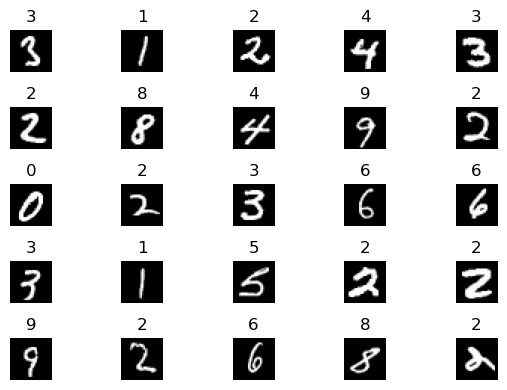

In [7]:
import matplotlib.pyplot as plt
import random

fig = plt.figure(dpi=100)
for ix in range(25):
	ax = plt.subplot(5, 5, ix + 1)
	i = random.randint(0, len(X_train)-1)
	img, label = X_train[i], y_train[i]
	ax.imshow(img.reshape(28,28), cmap='gray')
	ax.set_title(label)
	ax.axis('off')
plt.tight_layout()
plt.show()

En nuestra primera iteración, haremos un clasificador binario sencillo que detecte sólo el número 3. Más adelante iremos complicando los requisitos, lo cual nos dará opción a generar diferentes versiones de nuestro dataset y así ver un ejemplo de las herramientas necesarias para ello. Además, nos quedaremos con una pequeña muestra para empezar con un dataset limitado.

In [15]:
import numpy as np

X_train_3 = X_train[y_train == '3'][:100]
X_train_no_3 = X_train[y_train != '3'][:100]

len(X_train_3), len(X_train_no_3)

(100, 100)

In [18]:
def plot_samples(X):
	fig = plt.figure(dpi=100)
	for ix in range(25):
		ax = plt.subplot(5, 5, ix + 1)
		i = random.randint(0, len(X)-1)
		img = X[i]
		ax.imshow(img.reshape(28,28), cmap='gray')
		ax.axis('off')
	plt.tight_layout()
	plt.show()

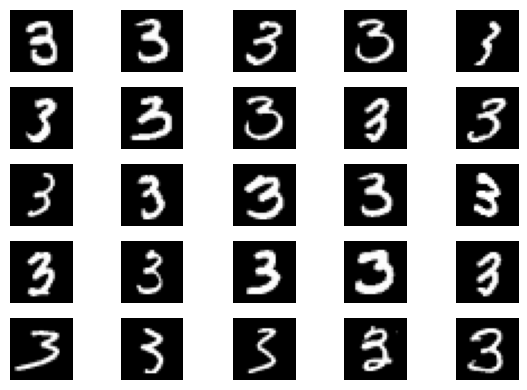

In [22]:
plot_samples(X_train_3)

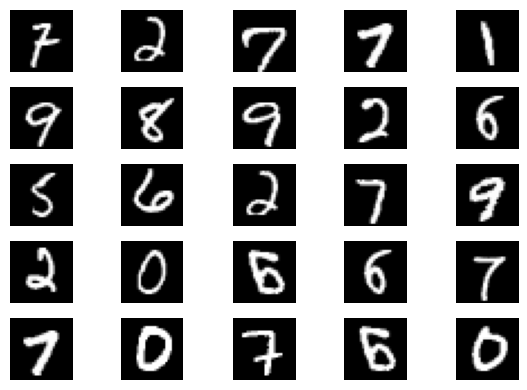

In [21]:
plot_samples(X_train_no_3)

Ahora guardaremos las imágenes en sendas carpetas, separando además un 20% de las muestras para el conjunto de test.

In [32]:
import os 
from pathlib import Path
from skimage.io import imsave
import shutil

path = Path('dataset')
shutil.rmtree(path)
os.makedirs(path, exist_ok=True)

splits = ['train', 'test']
for split in splits:
	os.makedirs(path / split, exist_ok=True)
	os.makedirs(path / split / '3', exist_ok=True)
	os.makedirs(path / split / 'no3', exist_ok=True)
	if split == 'train':
		X1, X2 = X_train_3[:80], X_train_no_3[:80]
	else:
		X1, X2 = X_train_3[80:], X_train_no_3[80:]
	for x1, x2 in zip(X1, X2):
		imsave(path / split / '3' / f'{random.randint(0, 99999):05d}.png', x1.reshape(28,28).astype('uint8'))
		imsave(path / split / 'no3' / f'{random.randint(0, 99999):05d}.png', x2.reshape(28,28).astype('uint8'))


In [36]:
from glob import glob

train_3 = glob(str(path / 'train' / '3' / '*.png'))
train_no3 = glob(str(path / 'train' / 'no3' / '*.png'))

len(train_3), len(train_no3)

(80, 80)

In [47]:
from skimage.io import imread 

def plot_images(paths):
	fig = plt.figure(dpi=100)
	for ix in range(25):
		ax = plt.subplot(5, 5, ix + 1)
		i = random.randint(0, len(paths)-1)
		img = imread(paths[i])
		ax.imshow(img, cmap='gray')
		ax.axis('off')
	plt.tight_layout()
	plt.show()

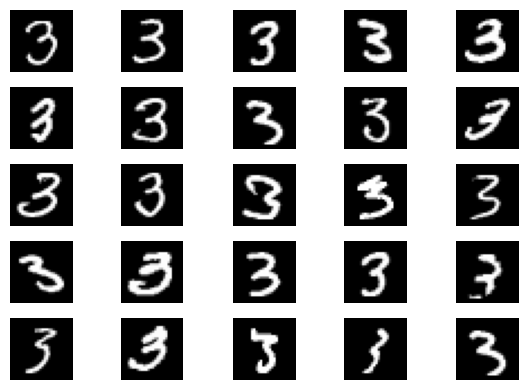

In [49]:
plot_images(train_3)

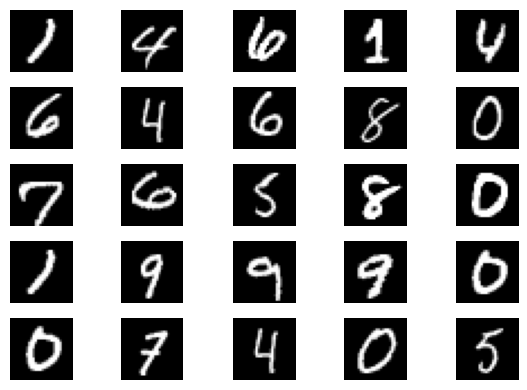

In [50]:
plot_images(train_no3)

Ahora podemos generar un archivo `.zip` con nuestro dataset ya listo para ser usado para entrenar modelos.

In [52]:
shutil.make_archive('datasetv0', 'zip', path)

'/home/juan/Desktop/blog/084_dlops_intro/datasetv0.zip'

Si el equipo de ingeniero quiere usar el dataset tendría que tener acceso a este zip. Podemos guardarlo en un servidor al que todos puedan entrar o, mejor, en la nube.

Qué pasa si mañana añadimos 100 ejemplos más ? o si cambiamos los splits ? o cuando queramos clasificar los 10 dígitos ? Necesitamos un sistema de control de versión. De la misma manera que [git](https://git-scm.com/) nos ayuda a versionar nuestro código, [dvc](https://dvc.org/) nos ayudará a versionar nuestros datasets y modelos. Además, lo hará con un sistema muy similar a git (ramas, commits, pull requests, ...).

Vamos a empezar instalando `dvc` con el comando:

```
pip install dvc
```

Acto seguido, inicializaremos un repositorio con el comando: 

```
dvc init
```

Deberás ejectuar el comando al mismo nivel que un repositorio de git, ya que `dvc` utiliza git para el control de version de los metadatos asociados a los datos (archivos grandes). Esto generará una carpeta `.dvc` y un archivo `.dvcignore` similar a git.

Ahora podemos añadir la carpeta con los datos al repositorio con el comando

```
dvc add dataset
```

El siguiente paso será conectar `dvc` con un servicio de almacenamiento remoto en el que guardar nuestros datos. Puedes utilizar diferentes servicios, [aquí](https://dvc.org/features) tienes una lista. En este caso utilizaremos un `bucket` de `firebase`, ya que más adelante usaremos otras características como la base de datos. Para que `dvc` pueda acceder al `bucket` necesitaremos configurar la variable de entorno `GOOGLE_APPLICATION_CREDENTIALS`, siguiendo la [documentación](https://cloud.google.com/docs/authentication/getting-started#command-line) o descargando desde la consola de firebase. Una vez conectado, podremos sincronizar nuestro dataset con el comando:


```
dvc push
```
